In [5]:
import re
from time import sleep
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver import ActionChains
from selenium.webdriver.common.actions.wheel_input import ScrollOrigin
from selenium.webdriver.common.keys import Keys

In [25]:
# scrape from Microsoft's earnings press releases and segment revenue reports

### CONSTANTS ###
BASE_URL = "https://www.microsoft.com/en-us/investor/earnings/"
EARNINGS_URL = "/press-release-webcast"
SEGMENT_REVENUE_URL = "/segment-revenues"

# dates of relevant reports
END_YEAR = 2024
END_QUARTER = 3

### Copilot is included in financial reports from FY23 Q4 ###

### HELPER FUNCTIONS ### 
# URL builder function
def url_builder(date, url_type):
    if url_type == "E":
        return BASE_URL + date + EARNINGS_URL
    elif url_type == "S":
        return BASE_URL + date + SEGMENT_REVENUE_URL
    
def extract_revenue_stats(text):
    # regular expression patterns
    revenue_pattern = r'Revenue was \$(\d+\.?\d*) billion'
    increase_pattern = r'increased (\d+)%'
    
    # find revenue
    revenue_match = re.search(revenue_pattern, text)
    if revenue_match:
        revenue = float(revenue_match.group(1))
    else:
        revenue = None
    
    # find increase percentage
    increase_match = re.search(increase_pattern, text)
    if increase_match:
        increase_percentage = int(increase_match.group(1))
    else:
        increase_percentage = None
        
    return [revenue, increase_percentage]

def extract_number(text):
    # remove non-numeric characters except for commas and periods
    cleaned_text = re.sub(r'[^\d,]', '', text)
    # remove commas for conversion to a number
    cleaned_text = cleaned_text.replace(',', '')
    # convert the cleaned text to an integer or float
    number = int(cleaned_text)
    return number

# scrape the press release page   
def scrape_press_release(url):
    driver = webdriver.Chrome()
    driver.get(url)
    
    sleep(2)
    
    # get revenue 
    revenue_paragraph = driver.find_elements(By.CLASS_NAME, "MsoListParagraphCxSpFirst")
    revenue_text = revenue_paragraph[0].text
    
    # extract numbers
    revenue_stats = extract_revenue_stats(revenue_text)
    
    driver.quit()
    
    return revenue_stats

quarter_indexes = {
    1: [0, 2, 4],
    2: [0, 4, 8],
    3: [0, 4, 8],
    4: [0, 3, 6],
    "cumulative q3": [2, 6, 10],
}

# scrape the revenue segments page   
def scrape_segment_revenue(url, quarter):
    driver = webdriver.Chrome()
    driver.get(url)
    
    sleep(2)
    
    # get indexes for quarter
    index = quarter_indexes.get(quarter)
    
    # get revenue 
    revenues = driver.find_elements(By.CLASS_NAME, "c-price")
    pbp_revenue = extract_number(revenues[index[0]].text)
    ic_revenue = extract_number(revenues[index[1]].text)
    mpc_revenue = extract_number(revenues[index[2]].text)
    
    driver.quit()
    
    return [pbp_revenue, ic_revenue, mpc_revenue]

In [96]:
# get overall revenue from earnings report
current_year = 2022
current_quarter = 1

revenue = {}
increase_percentage = {}

# loop until the end year and quarter
while not (current_year == END_YEAR and current_quarter == END_QUARTER + 1):
    # get current date
    date = f"FY-{current_year}-Q{current_quarter}"
    url = url_builder(date, "E")
    
    # scrape page results for revenue
    revenue_stats = scrape_press_release(url)
    revenue[date] = revenue_stats[0]
    increase_percentage[date] = revenue_stats[1]
    
    # increment the date
    current_quarter += 1 # increment the quarter
    if current_quarter > 4: # reset to 1 and increment the year if quarter > 4
        current_quarter = 1
        current_year += 1

print(revenue)
print(increase_percentage)

"""
[51.9, 12]
[50.1, 11]
[52.7, 2] Jan 2023
[52.9, 7]
[56.2, 8]
[56.5, 13] Oct 2023
[62.0, 18] Jan 2024
[61.9, 17]
"""

{'FY-2022-Q1': 45.3, 'FY-2022-Q2': 51.7, 'FY-2022-Q3': 49.4, 'FY-2022-Q4': 51.9, 'FY-2023-Q1': 50.1, 'FY-2023-Q2': 52.7, 'FY-2023-Q3': 52.9, 'FY-2023-Q4': 56.2, 'FY-2024-Q1': 56.5, 'FY-2024-Q2': 62.0, 'FY-2024-Q3': 61.9}
{'FY-2022-Q1': 22, 'FY-2022-Q2': 20, 'FY-2022-Q3': 18, 'FY-2022-Q4': 12, 'FY-2023-Q1': 11, 'FY-2023-Q2': 2, 'FY-2023-Q3': 7, 'FY-2023-Q4': 8, 'FY-2024-Q1': 13, 'FY-2024-Q2': 18, 'FY-2024-Q3': 17}


'\n[51.9, 12]\n[50.1, 11]\n[52.7, 2] Jan 2023\n[52.9, 7]\n[56.2, 8]\n[56.5, 13] Oct 2023\n[62.0, 18] Jan 2024\n[61.9, 17]\n'

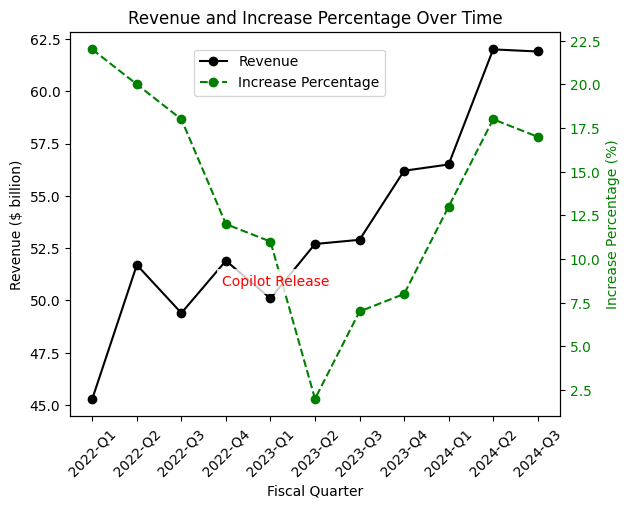

In [105]:
# visualise results
revenue = {'FY-2022-Q1': 45.3, 'FY-2022-Q2': 51.7, 'FY-2022-Q3': 49.4, 'FY-2022-Q4': 51.9, 'FY-2023-Q1': 50.1, 'FY-2023-Q2': 52.7, 'FY-2023-Q3': 52.9, 'FY-2023-Q4': 56.2, 'FY-2024-Q1': 56.5, 'FY-2024-Q2': 62.0, 'FY-2024-Q3': 61.9}
increase_percentage = {'FY-2022-Q1': 22, 'FY-2022-Q2': 20, 'FY-2022-Q3': 18, 'FY-2022-Q4': 12, 'FY-2023-Q1': 11, 'FY-2023-Q2': 2, 'FY-2023-Q3': 7, 'FY-2023-Q4': 8, 'FY-2024-Q1': 13, 'FY-2024-Q2': 18, 'FY-2024-Q3': 17}

quarters = list(revenue.keys())
revenue_values = list(revenue.values())
increase_values = list(increase_percentage.values())

# modify x-axis labels to show quarters
formatted_quarters = [q.replace('FY-', '') for q in quarters]

fig, ax1 = plt.subplots()

# plot revenue
color = "black"
ax1.set_xlabel('Fiscal Quarter')
ax1.set_ylabel('Revenue ($ billion)', color=color)
ax1.plot(formatted_quarters, revenue_values, color=color, marker='o', label='Revenue')
ax1.tick_params(axis='y', labelcolor=color)

# second y-axis for the increase percentage
ax2 = ax1.twinx()  
color = "green"
ax2.set_ylabel('Increase Percentage (%)', color=color)
ax2.plot(formatted_quarters, increase_values, color=color, marker='o', linestyle='--', label='Increase Percentage')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Revenue and Increase Percentage Over Time')
fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.3,0.9))
for tick in ax1.get_xticklabels(): # rotate labels by 45 degrees
    tick.set_rotation(45)
ax2.annotate('Copilot Release',
                xy=(0.42, 0.35),  
                xycoords='axes fraction',  
                ha='center', va='center', color="red",
                bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
plt.show()

# 2023 q3


In [70]:
# get segmented revenue 
### Copilot is included in Productivity and Business Processes from FY23 Q4 ###
### Copilot is included in More Personal Computing from FY24 Q2 ###
### Azure AI is released in FY21 Q4 ###

current_year = 2021
current_quarter = 2

productivity_and_business_processes = {}
intelligent_cloud = {}
personal_computing = {}

q3_cumulative = []

# loop until the end year and quarter
while not (current_year == END_YEAR and current_quarter == END_QUARTER + 1):
    # get current date
    date = f"FY-{current_year}-Q{current_quarter}"
    url = url_builder(date, "S")
    
    # scrape page results for revenue        
    segment_revenue = scrape_segment_revenue(url, current_quarter)
    if current_quarter != 4:
        productivity_and_business_processes[date] = segment_revenue[0]
        intelligent_cloud[date] = segment_revenue[1]
        personal_computing[date] = segment_revenue[2]
    
    # store q3 cumulative to subtract q4's yearly total
    # or calculate q4 revenue
    if current_quarter == 3:
        q3_cumulative = scrape_segment_revenue(url, "cumulative q3")
    elif current_quarter == 4:
        productivity_and_business_processes[date] = segment_revenue[0] - q3_cumulative[0]
        intelligent_cloud[date] = segment_revenue[1] - q3_cumulative[1]
        personal_computing[date] = segment_revenue[2] - q3_cumulative[2]
    
    # increment the date
    current_quarter += 1 # increment the quarter
    if current_quarter > 4: # reset to 1 and increment the year if quarter > 4
        current_quarter = 1
        current_year += 1

print(productivity_and_business_processes)
print(intelligent_cloud)
print(personal_computing)

productivity_and_business_processes = {'FY-2022-Q3': 15789, 'FY-2022-Q4': 16600, 'FY-2023-Q1': 16465, 'FY-2023-Q2': 17002, 'FY-2023-Q3': 17516, 'FY-2023-Q4': 18291, 'FY-2024-Q1': 18592, 'FY-2024-Q2': 19249, 'FY-2024-Q3': 19570}
intelligent_cloud = {'FY-2022-Q3': 19051, 'FY-2022-Q4': 20909, 'FY-2023-Q1': 20325, 'FY-2023-Q2': 21508, 'FY-2023-Q3': 22081, 'FY-2023-Q4': 23993, 'FY-2024-Q1': 24259, 'FY-2024-Q2': 25880, 'FY-2024-Q3': 26708}
personal_computing = {'FY-2022-Q3': 14520, 'FY-2022-Q4': 14356, 'FY-2023-Q1': 13332, 'FY-2023-Q2': 14237, 'FY-2023-Q3': 13260, 'FY-2023-Q4': 13905, 'FY-2024-Q1': 13666, 'FY-2024-Q2': 16891, 'FY-2024-Q3': 15580}


{'FY-2021-Q2': 13353, 'FY-2021-Q3': 13552, 'FY-2021-Q4': 14691, 'FY-2022-Q1': 15039, 'FY-2022-Q2': 15936, 'FY-2022-Q3': 15789, 'FY-2022-Q4': 16600, 'FY-2023-Q1': 16465, 'FY-2023-Q2': 17002, 'FY-2023-Q3': 17516, 'FY-2023-Q4': 18291, 'FY-2024-Q1': 18592, 'FY-2024-Q2': 19249, 'FY-2024-Q3': 19570}
{'FY-2021-Q2': 14601, 'FY-2021-Q3': 15118, 'FY-2021-Q4': 17375, 'FY-2022-Q1': 16964, 'FY-2022-Q2': 18327, 'FY-2022-Q3': 19051, 'FY-2022-Q4': 20909, 'FY-2023-Q1': 20325, 'FY-2023-Q2': 21508, 'FY-2023-Q3': 22081, 'FY-2023-Q4': 23993, 'FY-2024-Q1': 24259, 'FY-2024-Q2': 25880, 'FY-2024-Q3': 26708}
{'FY-2021-Q2': 15122, 'FY-2021-Q3': 13036, 'FY-2021-Q4': 14086, 'FY-2022-Q1': 13314, 'FY-2022-Q2': 17465, 'FY-2022-Q3': 14520, 'FY-2022-Q4': 14356, 'FY-2023-Q1': 13332, 'FY-2023-Q2': 14237, 'FY-2023-Q3': 13260, 'FY-2023-Q4': 13905, 'FY-2024-Q1': 13666, 'FY-2024-Q2': 16891, 'FY-2024-Q3': 15580}


C:\Users\jyin1\AppData\Local\Temp\ipykernel_40360\2567719338.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(data['Financial Year Quarter'], rotation=45, fontsize=12)


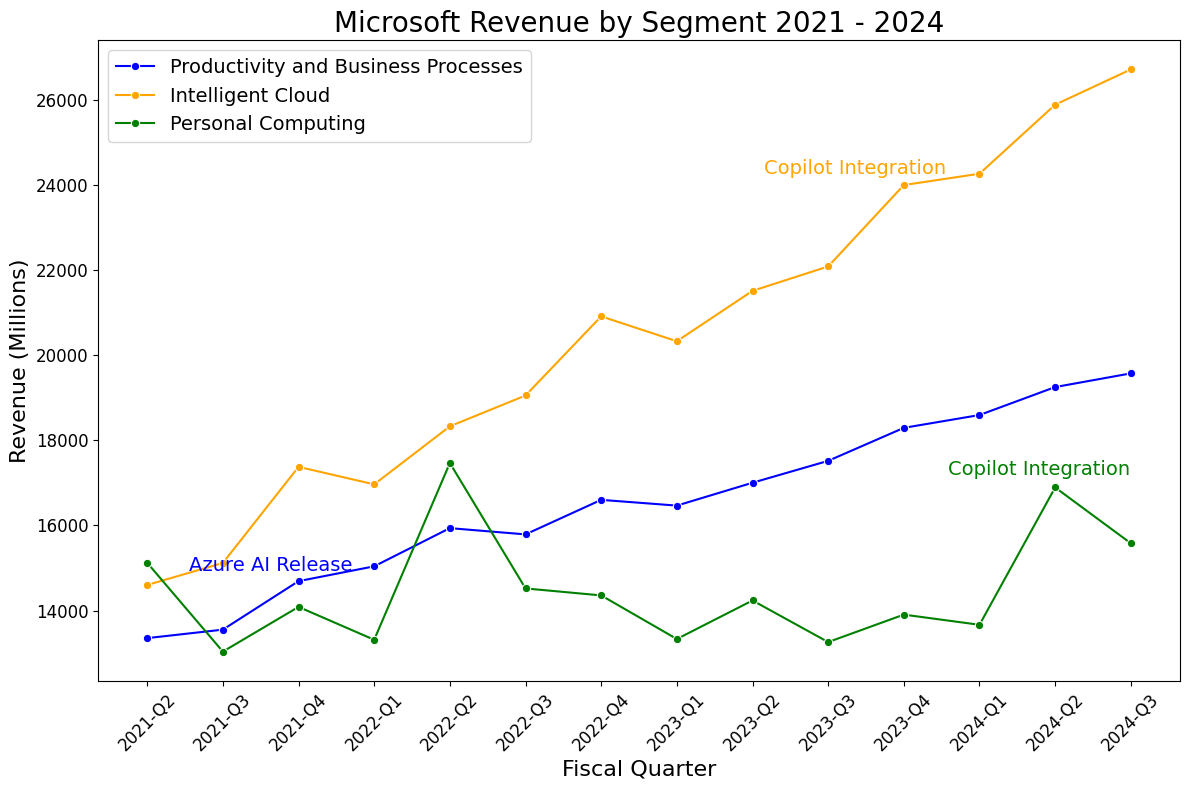

In [109]:
# visualise segment revenue data 
productivity_and_business_processes = {'FY-2021-Q2': 13353, 'FY-2021-Q3': 13552, 'FY-2021-Q4': 14691, 'FY-2022-Q1': 15039, 'FY-2022-Q2': 15936, 'FY-2022-Q3': 15789, 'FY-2022-Q4': 16600, 'FY-2023-Q1': 16465, 'FY-2023-Q2': 17002, 'FY-2023-Q3': 17516, 'FY-2023-Q4': 18291, 'FY-2024-Q1': 18592, 'FY-2024-Q2': 19249, 'FY-2024-Q3': 19570}
intelligent_cloud = {'FY-2021-Q2': 14601, 'FY-2021-Q3': 15118, 'FY-2021-Q4': 17375, 'FY-2022-Q1': 16964, 'FY-2022-Q2': 18327, 'FY-2022-Q3': 19051, 'FY-2022-Q4': 20909, 'FY-2023-Q1': 20325, 'FY-2023-Q2': 21508, 'FY-2023-Q3': 22081, 'FY-2023-Q4': 23993, 'FY-2024-Q1': 24259, 'FY-2024-Q2': 25880, 'FY-2024-Q3': 26708}
personal_computing = {'FY-2021-Q2': 15122, 'FY-2021-Q3': 13036, 'FY-2021-Q4': 14086, 'FY-2022-Q1': 13314, 'FY-2022-Q2': 17465, 'FY-2022-Q3': 14520, 'FY-2022-Q4': 14356, 'FY-2023-Q1': 13332, 'FY-2023-Q2': 14237, 'FY-2023-Q3': 13260, 'FY-2023-Q4': 13905, 'FY-2024-Q1': 13666, 'FY-2024-Q2': 16891, 'FY-2024-Q3': 15580}

data = pd.DataFrame({
    'Financial Year Quarter': list(productivity_and_business_processes.keys()),
    'Productivity and Business Processes': list(productivity_and_business_processes.values()),
    'Intelligent Cloud': list(intelligent_cloud.values()),
    'Personal Computing': list(personal_computing.values())
})

data['Financial Year Quarter'] = data['Financial Year Quarter'].str.replace('FY-', '')

# Plot
fig, ax1 = plt.subplots(figsize=(12, 8))

sns.lineplot(data=data, x='Financial Year Quarter', y='Productivity and Business Processes', ax=ax1, color='blue', marker='o', label='Productivity and Business Processes')
sns.lineplot(data=data, x='Financial Year Quarter', y='Intelligent Cloud', ax=ax1, color='orange', marker='o', label='Intelligent Cloud')
sns.lineplot(data=data, x='Financial Year Quarter', y='Personal Computing', ax=ax1, color='green', marker='o', label='Personal Computing')

plt.title('Microsoft Revenue by Segment 2021 - 2024', fontsize=20)
plt.xlabel('Fiscal Quarter', fontsize=16)
plt.ylabel('Revenue (Millions)', fontsize=16)
plt.legend(fontsize=14)

ax1.annotate('Copilot Integration',
                xy=(0.7, 0.8),  
                xycoords='axes fraction',  
                ha='center', va='center', color="orange", fontsize=14)
ax1.annotate('Azure AI Release',
                xy=(0.16, 0.18),  
                xycoords='axes fraction',  
                ha='center', va='center', color="blue", fontsize=14)
ax1.annotate('Copilot Integration',
                xy=(0.87, 0.33),  
                xycoords='axes fraction',  
                ha='center', va='center', color="green", fontsize=14)

ax1.set_xticklabels(data['Financial Year Quarter'], rotation=45, fontsize=12)
ax1.tick_params(axis='y', labelsize=12)

plt.tight_layout()
plt.show()